# LIVRABLE 2 - Traitement d'images

Objectif : Débruiter un ensemble d’images RGB afin de les rendre plus exploitables par les algorithmes en s’appuyant sur des auto-encodeurs convolutifs.

# Partie 1 : Import des bibliothèques

Cette partie importe l’ensemble des bibliothèques nécessaires au traitement d’images, à la construction du modèle de débruitage, et à l’évaluation des performances.

TensorFlow pour l’architecture de l’auto-encodeur, OpenCV et PIL pour la gestion des images, et skimage pour le calcul du PSNR.

In [12]:
import os
import numpy as np
import cv2
import glob
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,  BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pathlib import Path


# Partie 2 : Chargement et préparation des images

Cette partie charge les images RGB du dossier imagesL2, les redimensionne en 256x256 pixels, les convertit au format RGB (au lieu de BGR par défaut avec OpenCV), puis on les normalise sur [0, 1] 

In [13]:
img_size = 256 
image_folder = "./datasets/imagesL2"
X = []

image_paths = sorted(glob.glob(os.path.join(image_folder, "*.jpg")))

for path in tqdm(image_paths, desc="Chargement avec OpenCV (128x128)"):
    img = cv2.imread(path)  # BGR
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
    img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    X.append(img)

X = np.array(X)
print(f"[INFO] {len(X)} images chargées avec OpenCV à {img_size}x{img_size}")

Chargement avec OpenCV (128x128): 100%|██████████| 148/148 [00:00<00:00, 307.77it/s]


[INFO] 148 images chargées avec OpenCV à 256x256


# Partie 3 : Ajout de bruit gaussien

Afin d’entraîner l’auto-encodeur à débruiter les images, on génère ici une version bruitée du dataset en y ajoutant du bruit gaussien.  
On applique donc ce bruit à chaque image

Un exemple visuel est affiché juste en dessous pour comparer une image originale et sa version bruitée avev un std de 0.5

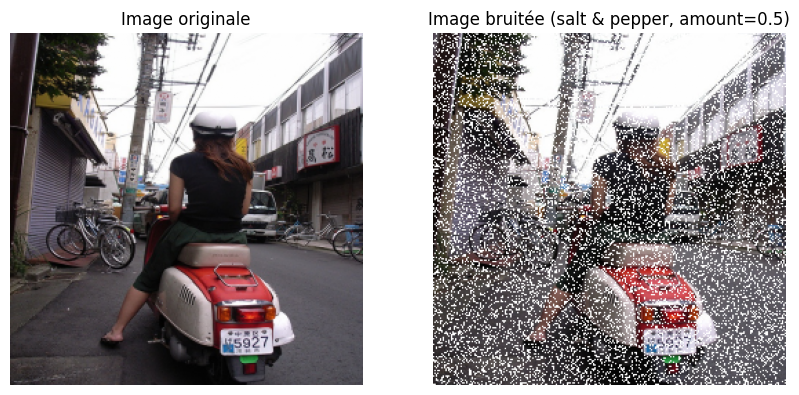

In [ ]:
def add_salt_noise(images, amount=0.05, show_example=False):
    noisy_images = []

    for img in images:
        noisy_img = img.copy()
        total_pixels = img.shape[0] * img.shape[1]

        # Nombre de pixels à bruiter
        num_salt = int(amount * total_pixels / 2)
        num_pepper = int(amount * total_pixels / 2)

        # Salt (blanc)
        coords = [np.random.randint(0, i, num_salt) for i in img.shape[:2]]
        noisy_img[coords[0], coords[1]] = 1

        noisy_images.append(noisy_img)

    noisy_images = np.array(noisy_images)

    if show_example:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(images[2])
        plt.title("Image originale")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(noisy_images[2])
        plt.title(f"Image bruitée (salt amount={amount})")
        plt.axis("off")
        plt.show()

    return noisy_images

X_noisy = add_salt_noise(X, amount=0.5, show_example=True)

# Partie 4 : Modèle de débruitage

Dans cette étape, on définit un auto-encodeur convolutif basé sur une architecture Mini U-Net, conçu pour restaurer les images bruitées.  
Ce modèle encode les caractéristiques principales de l’image puis les reconstruit pour préserver les détails.

Il intègre aussi un Batch Normalization pour stabiliser l’apprentissage

In [15]:
def build_mini_unet(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    # Encodeur
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = BatchNormalization()(b)

    # Décodeur
    u1 = UpSampling2D((2, 2))(b)
    u1 = Concatenate()([u1, c2])
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c3 = BatchNormalization()(c3)

    u2 = UpSampling2D((2, 2))(c3)
    u2 = Concatenate()([u2, c1])
    c4 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c4 = BatchNormalization()(c4)

    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c4)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-3), loss='mse')
    return model

model = build_mini_unet(input_shape=(256, 256, 3))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 192)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │    110,656 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 256,  │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 96)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │     27,680 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_10[0][0] 

 Total params: 233,731 (913.01 KB)

 Trainable params: 233,091 (910.51 KB)

 Non-trainable params: 640 (2.50 KB)

# Partie 5 : Entraînement du modèle

Dans cette étape, on entraîne le modèle à partir des paires (image bruitée -> image propre), avec une validation sur 20 % du dataset.  
L'entraînement utilise un petit batch size (4) pour limiter la mémoire GPU, et on s’appuie sur deux callbacks :

- `EarlyStopping` pour arrêter l'entraînement en cas de stagnation de la validation.
- `ReduceLROnPlateau` pour réduire le taux d’apprentissage si la performance ne s’améliore plus.

L’objectif est de minimiser l’erreur de reconstruction (MSE) entre l’image débruitée et l’image originale.


In [16]:
callbacks = [
    EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]

history = model.fit(
    X_noisy, X,  # image bruitée → image propre
    batch_size=4,
    epochs=200,
    validation_split=0.2,
    shuffle=True,
    callbacks=callbacks
)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 24s 737ms/step - loss: 0.0377 - val_loss: 0.0801 - learning_rate: 0.0010
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 699ms/step - loss: 0.0130 - val_loss: 0.0618 - learning_rate: 0.0010
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - loss: 0.0117 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 698ms/step - loss: 0.0086 - val_loss: 0.0487 - learning_rate: 0.0010
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 692ms/step - loss: 0.0078 - val_loss: 0.0473 - learning_rate: 0.0010
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 694ms/step - loss: 0.0074 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 704ms/step - loss: 0.0086 - val_loss: 0.0369 - learning_rate: 0.0010
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - loss: 0.0082 - val_loss: 0.0233 - learning_rate: 0.0010
Epoch 9/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 21s 697ms/step - loss: 0.0067 - val_loss: 0.0236 - learning_rate:

# Partie 6 : Évaluation visuelle du modèle

Dans cette étape, on évalue visuellement les performances du modèle sur un échantillon d’images.  
Pour chaque exemple, on affiche côte à côte :

- l’image originale,
- sa version bruitée,
- l’image restaurée par le modèle.

On calcule également la PSNR (Peak Signal-to-Noise Ratio) pour chaque image, pour mesurer la qualité de reconstruction.  
Plus la PSNR est élevée, plus l’image débruitée est proche de l’originale.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


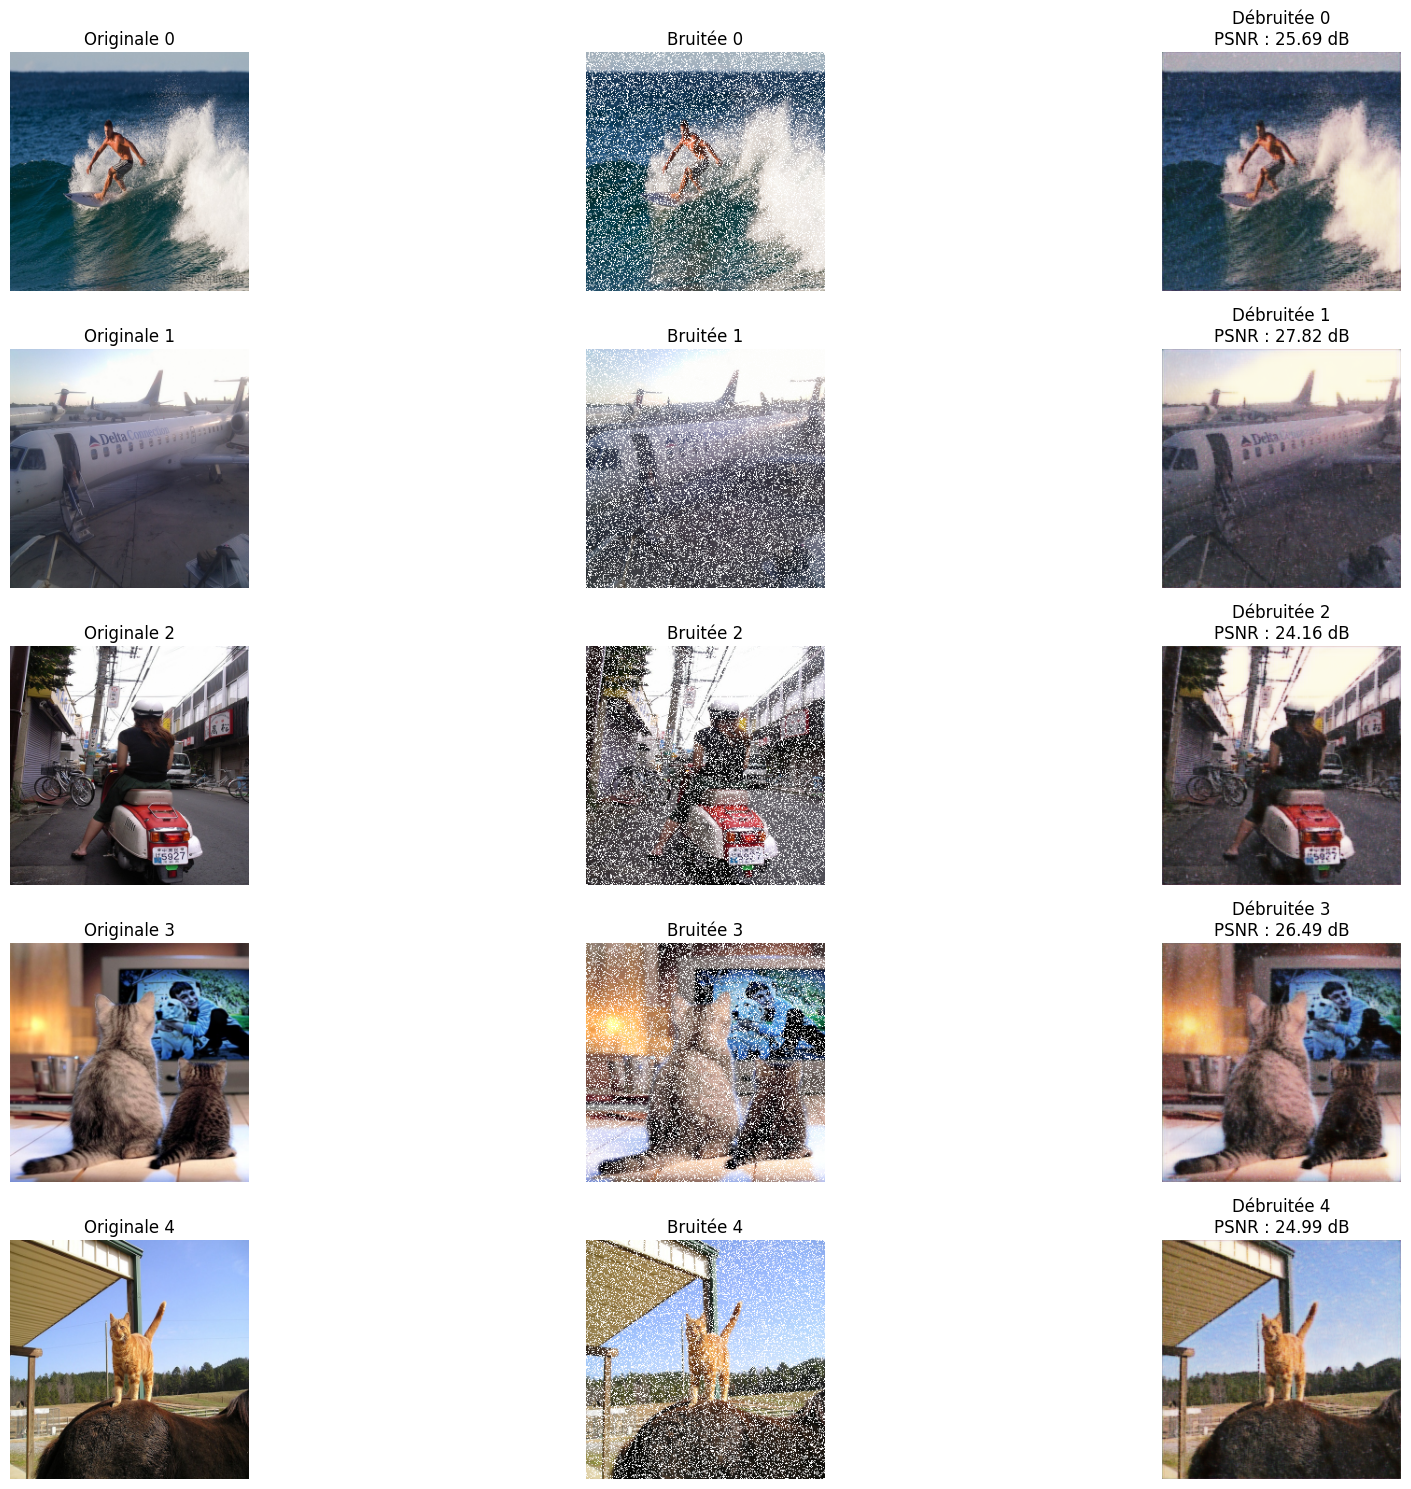

In [17]:
plt.figure(figsize=(20, 15))

for i in range(5):
    # Prédiction
    denoised_img = model.predict(np.expand_dims(X_noisy[i], axis=0))[0]
    denoised_img = np.clip(denoised_img, 0., 1.)
    
    # PSNR individuel
    image_psnr = psnr(X[i], denoised_img, data_range=1.0)

    # Ligne i → 3 colonnes : originale, bruitée, débruitée
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(X[i])
    plt.title(f"Originale {i}")
    plt.axis("off")

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(X_noisy[i])
    plt.title(f"Bruitée {i}")
    plt.axis("off")

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(denoised_img)
    plt.title(f"Débruitée {i}\nPSNR : {image_psnr:.2f} dB")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Sauvegarde du modèle

Cette cellule enregistre le modèle entraîné au format `.h5` pour le réutiliser plus tard sans le réentraîner.

In [18]:
# Chemin de sauvegarde
model_path = "salt_noise.h5"

# Sauvegarde du modèle
model.save(model_path)

print(f"Modèle sauvegardé sous : {model_path}")

Modèle sauvegardé sous : salt_noise.h5


# Partie 7 : Évaluation quantitative

Dans cette dernière étape, on évalue les performances globales du modèle sur l’ensemble des images en utilisant deux métriques :

- **PSNR** (Peak Signal-to-Noise Ratio) : mesure la qualité de la reconstruction en comparant l’image restaurée à l’originale.
- **SSIM** (Structural Similarity Index) : mesure la similarité structurelle entre deux images.

On affiche ensuite la moyenne des valeurs des deux métriques pour juger de la qualité du modèle

In [19]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Nombre d'images à évaluer (tu peux réduire pour aller plus vite)
n_samples = len(X)

psnr_total = 0
ssim_total = 0

for i in range(n_samples):
    denoised = model.predict(np.expand_dims(X_noisy[i], axis=0))[0]
    denoised = np.clip(denoised, 0., 1.)

    # PSNR
    psnr_val = psnr(X[i], denoised, data_range=1.0)
    psnr_total += psnr_val

    # SSIM (moyenne des 3 canaux RGB)
    ssim_rgb = np.mean([
        ssim(X[i][:, :, c], denoised[:, :, c], data_range=1.0)
        for c in range(3)
    ])
    ssim_total += ssim_rgb

# Moyennes
avg_psnr = psnr_total / n_samples
avg_ssim = ssim_total / n_samples

print(f"Moyenne PSNR sur {n_samples} images : {avg_psnr:.2f} dB")
print(f" Moyenne SSIM sur {n_samples} images : {avg_ssim:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

### Conclusion

Le modèle U-Net a été entraîné uniquement avec du bruit de type **"salt"** (pixels blancs aléatoires), ce qui simule un type d’erreur fréquent sur certains capteurs ou lors de surexpositions.  
Ce choix permet de cibler un **bruit plus spécifique**, tout en facilitant l'apprentissage du modèle sur un petit dataset.

Les performances obtenues sont très satisfaisantes :

- **PSNR moyen** : 25.76 dB  
- **SSIM moyen** : 0.7858

Ces résultats montrent que le modèle parvient à **corriger efficacement les artefacts blancs**, tout en préservant les détails visuels des images d'origine.